# 12 Problemset

## Setup

**Instructions:** Preferably run this notebook on a GPU. On Google Colab, you can do this by selecting Runtime > Change Runtime Type > Hardware Acceleration > GPU. Start by loading the necessary libraries as follows:

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy
import cv2
%matplotlib inline

: 

: 

## 12.1 Constructing a bump function using neural networks

*   Write down the formula of the bump function which is realized by the neural network below. 

$Output=\rho_2 (\rho_1 (Input⋅w_1+b_1)^T⋅w_2+b_2)$
1.  $\rho_1$ and $\rho_2$ are RELU activation function
2.  $w_1=\begin{pmatrix}1&1&1&0&0&0\\0&0&0&1&1&1\end{pmatrix}$
3.  $b_1=\begin{pmatrix}0&-1&-2&0&-1&-2\end{pmatrix}$
4.  $w_2=\begin{pmatrix}1&-2&1&1&-2&1\end{pmatrix}$
5.  $b_2=\begin{pmatrix}-1\end{pmatrix}$


*   Draw the computational graph of the network (i.e., the graph whose vertices are neurons and whose edges are non-zero weights).

In [ ]:
input_shape = (None, 1, 2) # (sample size, number of bump functions, spatial dimension)
w1 = np.array([[[1,1,1,0,0,0], [0,0,0,1,1,1]]], dtype='float32')
b1 = np.array([0,-1,-2,0,-1,-2], dtype='float32')
w2 = np.array([1,-2,1,1,-2,1], dtype='float32')
b2 = np.array([-1], dtype='float32')
bump = tf.keras.models.Sequential([
  tf.keras.Input(shape=(1,2)),
  tf.keras.layers.Conv1D(
    6, 
    1, 
    padding='same', 
    strides=1, 
    activation='relu', 
    kernel_initializer=tf.keras.initializers.Constant(w1),
    bias_initializer=tf.keras.initializers.Constant(b1),
    trainable=False),
  tf.keras.layers.Dense(
    1, 
    activation='relu', 
    kernel_initializer=tf.keras.initializers.Constant(w2),
    bias_initializer=tf.keras.initializers.Constant(b2),
    trainable=False)])

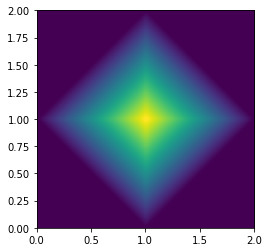

In [ ]:
xy = np.array([[[x,y]] for x in np.linspace(0,2,100) for y in np.linspace(0,2,100)],dtype='float32')
z = np.reshape(bump(xy),(100,100))
plt.imshow(z, extent=(0,2,0,2))

## 12.2 Image reconstruction using neural networks

*   Sketch the computational graph of the network which is implemented by the network below. 
*   Plot the output of the network *before* training. How does it depend on the parameter `stddev` which is used in the random initialization of the bottom layer? 
*   What initialization of the bottom layer would correspond to wavelet-like scalings and translations? Does this coincide with any readily [implemented](https://keras.io/api/layers/initializers/) network initialization? 
*   Find out what kind of output the network produces outside of the boundary of the image. 

In [ ]:
n_bumps = 1000
n_channels = 3
w1 = np.array([[[1,1,1,0,0,0], [0,0,0,1,1,1]]], dtype='float32')
b1 = np.array([0,-1,-2,0,-1,-2], dtype='float32')
w2 = np.array([1,-2,1,1,-2,1], dtype='float32')
b2 = np.array([-1], dtype='float32')
model = tf.keras.models.Sequential([
  tf.keras.Input(shape=(2,)),
  tf.keras.layers.Dense(
      2*n_bumps, 
      kernel_initializer = tf.keras.initializers.RandomNormal(stddev=5.),
      bias_initializer = tf.keras.initializers.RandomNormal(stddev=5.)),
  tf.keras.layers.Reshape((n_bumps,2)),
  tf.keras.layers.Conv1D(
    6, 
    1, 
    padding='same', 
    strides=1, 
    activation='relu', 
    kernel_initializer=tf.keras.initializers.Constant(w1),
    bias_initializer=tf.keras.initializers.Constant(b1),
    trainable=False),
  tf.keras.layers.Dense(
    1, 
    activation='relu', 
    kernel_initializer=tf.keras.initializers.Constant(w2),
    bias_initializer=tf.keras.initializers.Constant(b2),
    trainable=False),
  tf.keras.layers.Reshape((n_bumps,)),
  tf.keras.layers.Dense(n_channels)])
model.compile(optimizer="adam", loss='mean_squared_error')

(48, 64, 3)


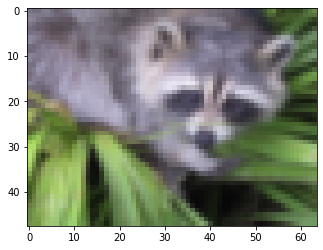

In [ ]:
img = scipy.misc.face()
img = cv2.pyrDown(img)
img = cv2.pyrDown(img)
img = cv2.pyrDown(img)
img = cv2.pyrDown(img)
plt.imshow(img)
print(img.shape)
plt.imshow(img)
xy = 2.*np.array([[x/img.shape[0], y/img.shape[1]] 
          for x in np.arange(img.shape[0]) 
          for y in np.arange(img.shape[1])], 
          dtype='float32') - 1.
rgb = img.reshape((img.shape[0]*img.shape[1],img.shape[2])) / 255. - 0.5
data = tf.data.Dataset.from_tensor_slices((xy, rgb)).shuffle(2000).batch(20)

In [ ]:
history = model.fit(data, epochs=30, verbose=0)

96/96 [==============================] - 0s 1ms/step


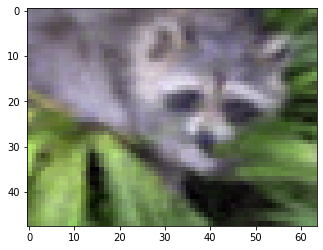

In [ ]:
plt.imshow(model.predict(xy).reshape(img.shape) + 0.5)

In [ ]:
# Before training
plt.imshow(model.predict(xy).reshape(img.shape)+0.5)

In [ ]:
model1 = tf.keras.models.Sequential([
  tf.keras.Input(shape=(2,)),
  tf.keras.layers.Dense(
      2*n_bumps, 
      kernel_initializer = tf.keras.initializers.RandomNormal(stddev=1.),
      bias_initializer = tf.keras.initializers.RandomNormal(stddev=1.)),
  tf.keras.layers.Reshape((n_bumps,2)),
  tf.keras.layers.Conv1D(
    6, 
    1, 
    padding='same', 
    strides=1, 
    activation='relu', 
    kernel_initializer=tf.keras.initializers.Constant(w1),
    bias_initializer=tf.keras.initializers.Constant(b1),
    trainable=False),
  tf.keras.layers.Dense(
    1, 
    activation='relu', 
    kernel_initializer=tf.keras.initializers.Constant(w2),
    bias_initializer=tf.keras.initializers.Constant(b2),
    trainable=False),
  tf.keras.layers.Reshape((n_bumps,)),
  tf.keras.layers.Dense(n_channels)])
model1.compile(optimizer="adam", loss='mean_squared_error')
plt.imshow(model1.predict(xy).reshape(img.shape)+0.5)

In [ ]:
model1 = tf.keras.models.Sequential([
  tf.keras.Input(shape=(2,)),
  tf.keras.layers.Dense(
      2*n_bumps, 
      kernel_initializer = tf.keras.initializers.RandomNormal(stddev=10.),
      bias_initializer = tf.keras.initializers.RandomNormal(stddev=10.)),
  tf.keras.layers.Reshape((n_bumps,2)),
  tf.keras.layers.Conv1D(
    6, 
    1, 
    padding='same', 
    strides=1, 
    activation='relu', 
    kernel_initializer=tf.keras.initializers.Constant(w1),
    bias_initializer=tf.keras.initializers.Constant(b1),
    trainable=False),
  tf.keras.layers.Dense(
    1, 
    activation='relu', 
    kernel_initializer=tf.keras.initializers.Constant(w2),
    bias_initializer=tf.keras.initializers.Constant(b2),
    trainable=False),
  tf.keras.layers.Reshape((n_bumps,)),
  tf.keras.layers.Dense(n_channels)])
model1.compile(optimizer="adam", loss='mean_squared_error')
plt.imshow(model1.predict(xy).reshape(img.shape)+0.5)

In [ ]:
history = model.fit(data, epochs=30, verbose=0)